## Gradient Boosting

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

Then, we start the cycle:

* First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
* These predictions are used to calculate a loss function (like mean squared error, for instance).
* Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
* Finally, we add the new model to ensemble, and ...
* ... repeat!
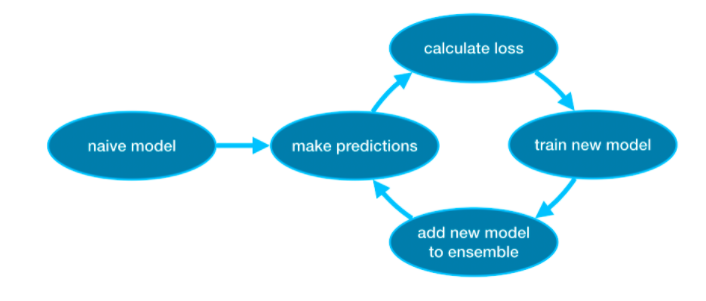

## Example

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('D:/lh_data/kaggle/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In this example, you'll work with the XGBoost library. XGBoost stands for extreme gradient boosting, which is an implementation of gradient boosting with several additional features focused on performance and speed. (Scikit-learn has another version of gradient boosting, but XGBoost has some technical advantages.)

In the next code cell, we import the scikit-learn API for XGBoost (xgboost.XGBRegressor). This allows us to build and fit a model just as we would in scikit-learn. As you'll see in the output, the XGBRegressor class has many tunable parameters -- you'll learn about those soon!

In [2]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [3]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 239473.742419919


## Parameter Tuning

XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

n_estimators
n_estimators specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.

* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the learning_rate parameter discussed below.

Here is the code to set the number of models in the ensemble:

In [4]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### early_stopping_rounds

early_stopping_rounds offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. Setting early_stopping_rounds=5 is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using early_stopping_rounds, you also need to set aside some data for calculating the validation scores - this is done by setting the eval_set parameter.

We can modify the example above to include early stopping:

* If you later want to fit a model with all of your data, set n_estimators to whatever value you found to be optimal when run with early stopping.

In [5]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### learning_rate

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for n_estimators without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1.

Modifying the example above to change the learning rate yields the following code:

In [6]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### n_jobs
On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.

Here's the modified example:

In [7]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Conclusion
XGBoost is a the leading software library for working with standard tabular data (the type of data you store in Pandas DataFrames, as opposed to more exotic types of data like images and videos). With careful parameter tuning, you can train highly accurate models.

# EXCERCISE

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('D:/lh_data/kaggle/train.csv', index_col='Id')
X_test_full = pd.read_csv('D:/lh_data/kaggle/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()



In [9]:
# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)


In [10]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,0,1,0,0,0,0,0,0,0,1
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,0,0,0,1,0,0,0,0,1,0
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,0,0,0,1,0,0,0,0,1,0
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
X_valid.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
530,20,NaN,32668,6,3,1957,1975,NaN,1219,0,...,0,0,0,1,0,0,1,0,0,0
492,50,79.0,9490,6,7,1941,1950,0.0,403,165,...,0,0,0,1,0,0,0,0,1,0
460,50,NaN,7015,5,4,1950,1950,161.0,185,0,...,0,0,0,1,0,0,0,0,1,0
280,60,83.0,10005,7,5,1977,1977,299.0,392,0,...,0,0,0,1,0,0,0,0,1,0
656,160,21.0,1680,6,5,1971,1971,381.0,0,0,...,0,0,0,1,0,0,0,1,0,0


DataFrame.align() method. This method aligns two objects on their axes with the specified join method. This method is helpful when we want to synchronize a dataframe with another dataframe or a dataframe with a Series using different join methods like the outer, inner, left, and right.

In [12]:
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [13]:
X_valid.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
530,20,NaN,32668,6,3,1957,1975,NaN,1219,0,...,NaN,0,0,1,0,0,1,0,0,0
492,50,79.0,9490,6,7,1941,1950,0.0,403,165,...,NaN,0,0,1,0,0,0,0,1,0
460,50,NaN,7015,5,4,1950,1950,161.0,185,0,...,NaN,0,0,1,0,0,0,0,1,0
280,60,83.0,10005,7,5,1977,1977,299.0,392,0,...,NaN,0,0,1,0,0,0,0,1,0
656,160,21.0,1680,6,5,1971,1971,381.0,0,0,...,NaN,0,0,1,0,0,0,1,0,0


## Step 1: Build model
### Part A

In this step, you'll build and train your first model with gradient boosting.

* Begin by setting my_model_1 to an XGBoost model. Use the XGBRegressor class, and set the random seed to 0 (random_state=0). Leave all other parameters as default.
* Then, fit the model to the training data in X_train and y_train.

In [14]:
from xgboost import XGBRegressor
my_model_1 = XGBRegressor(random_state=0)
my_model_1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Part B

Set predictions_1 to the model's predictions for the validation data. Recall that the validation features are stored in X_valid.

In [15]:
from sklearn.metrics import mean_absolute_error

# Get predictions
predictions_1 = my_model_1.predict(X_valid)
mae_1 = mean_absolute_error(predictions_1, y_valid)
print("Mean Absolute Error: " + str(mae_1))

Mean Absolute Error: 17662.736729452055


In [18]:
model_1 = XGBRegressor(n_estimators=100, random_state=0)
model_2 = XGBRegressor(n_estimators=200, random_state=0)
model_3 = XGBRegressor(n_estimators=300, random_state=0)
model_4 = XGBRegressor(n_estimators=400, random_state=0)
model_5 = XGBRegressor(n_estimators=500, random_state=0)
model_6 = XGBRegressor(n_estimators=600, random_state=0)
model_7 = XGBRegressor(n_estimators=700, random_state=0)
model_8 = XGBRegressor(n_estimators=800, random_state=0)
model_9 = XGBRegressor(n_estimators=900, random_state=0)
model_10 = XGBRegressor(n_estimators=1000, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 17662
Model 2 MAE: 17669
Model 3 MAE: 17670
Model 4 MAE: 17669
Model 5 MAE: 17669
Model 6 MAE: 17669
Model 7 MAE: 17669
Model 8 MAE: 17669
Model 9 MAE: 17669
Model 10 MAE: 17669


In [19]:
model_1 = XGBRegressor(n_estimators=100, learning_rate=0.01, random_state=0)
model_2 = XGBRegressor(n_estimators=100, learning_rate=0.02, random_state=0)
model_3 = XGBRegressor(n_estimators=100, learning_rate=0.03, random_state=0)
model_4 = XGBRegressor(n_estimators=100, learning_rate=0.04, random_state=0)
model_5 = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=0)
model_6 = XGBRegressor(n_estimators=100, learning_rate=0.06, random_state=0)
model_7 = XGBRegressor(n_estimators=100, learning_rate=0.07, random_state=0)
model_8 = XGBRegressor(n_estimators=100, learning_rate=0.08, random_state=0)
model_9 = XGBRegressor(n_estimators=100, learning_rate=0.09, random_state=0)
model_10 = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))


Model 1 MAE: 68584
Model 2 MAE: 29190
Model 3 MAE: 19464
Model 4 MAE: 17917
Model 5 MAE: 17213
Model 6 MAE: 17157
Model 7 MAE: 17502
Model 8 MAE: 17351
Model 9 MAE: 16754
Model 10 MAE: 17388


In [20]:
model_1 = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=0)
model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.02, random_state=0)
model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.03, random_state=0)
model_4 = XGBRegressor(n_estimators=1000, learning_rate=0.04, random_state=0)
model_5 = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0)
model_6 = XGBRegressor(n_estimators=1000, learning_rate=0.06, random_state=0)
model_7 = XGBRegressor(n_estimators=1000, learning_rate=0.07, random_state=0)
model_8 = XGBRegressor(n_estimators=1000, learning_rate=0.08, random_state=0)
model_9 = XGBRegressor(n_estimators=1000, learning_rate=0.09, random_state=0)
model_10 = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))


Model 1 MAE: 16913
Model 2 MAE: 16881
Model 3 MAE: 16849
Model 4 MAE: 17140
Model 5 MAE: 16688
Model 6 MAE: 16766
Model 7 MAE: 17161
Model 8 MAE: 17363
Model 9 MAE: 16649
Model 10 MAE: 17308


In [21]:
from xgboost import XGBRegressor
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.09, random_state=0)
my_model_2.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error

# Get predictions
predictions_2 = my_model_2.predict(X_valid)
mae_2 = mean_absolute_error(predictions_2, y_valid)
print("Mean Absolute Error: " + str(mae_2))

Mean Absolute Error: 16649.47391374144
